In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_column(df, column, color):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ano'], df[column], color=color)
    plt.xlabel('Ano')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.grid(True)
    plt.show()

In [3]:
df = pd.read_csv('pib_santa_catarina.csv')
df

,Ano,Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado
0,1985,1.571585e-02,2.181601e+06,16.895045,6.830805e+07
1,1986,4.479397e-02,3.049726e+06,18.093597,7.469301e+07
2,1987,1.382425e-01,2.040190e+06,18.502973,7.793441e+07
3,1988,1.032434e+00,2.825931e+06,18.025314,7.740263e+07
4,1989,1.783700e+01,3.581074e+06,18.035773,8.095934e+07
5,1990,4.312081e+02,2.624191e+06,17.294266,7.898703e+07
6,1991,2.105984e+03,2.913046e+06,17.486292,8.120389e+07
7,1992,2.478456e+04,3.049319e+06,17.756511,8.405240e+07
8,1993,5.011686e+05,2.979247e+06,18.432088,8.874488e+07
9,1994,1.278015e+07,3.913354e+06,18.735929,9.171157e+07


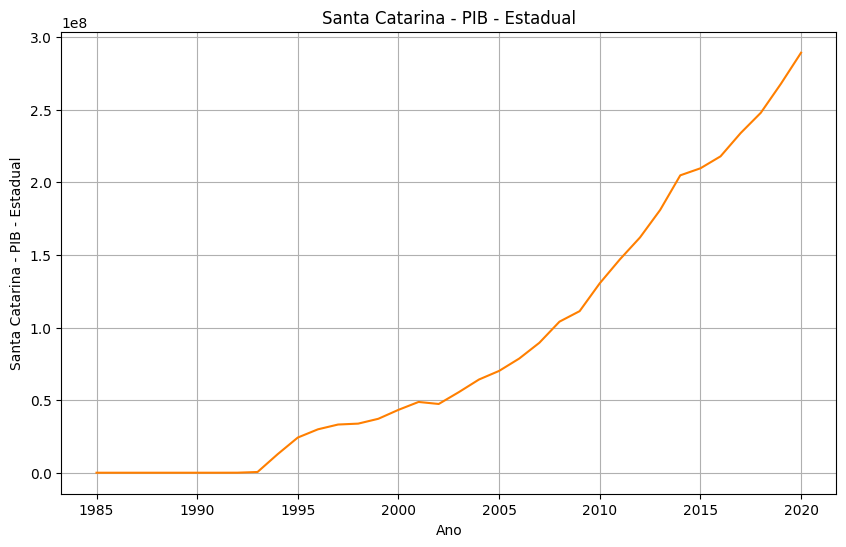

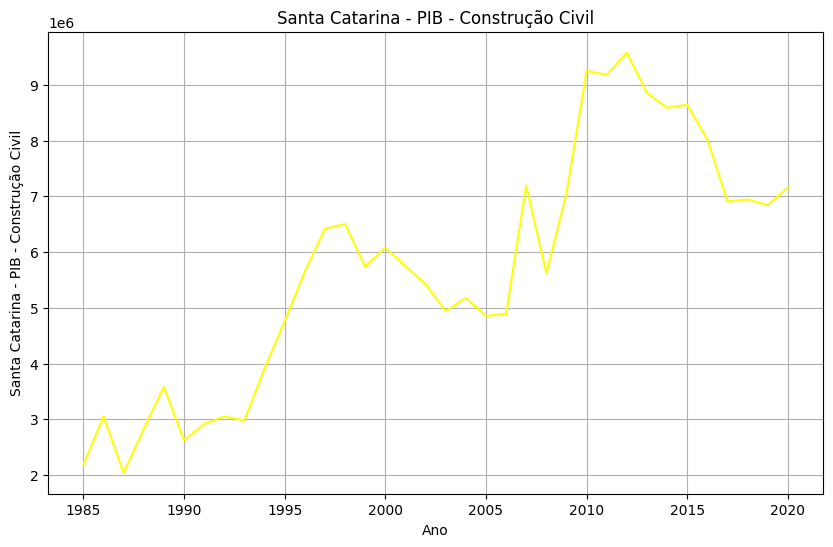

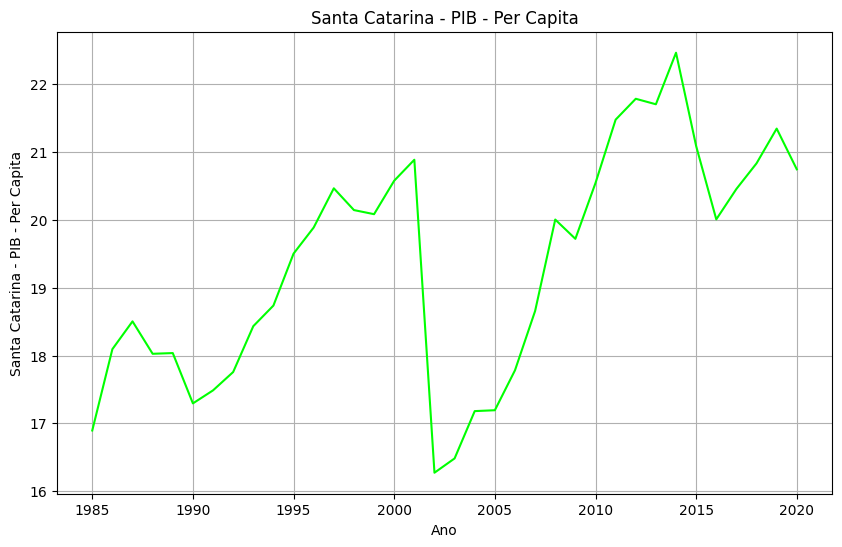

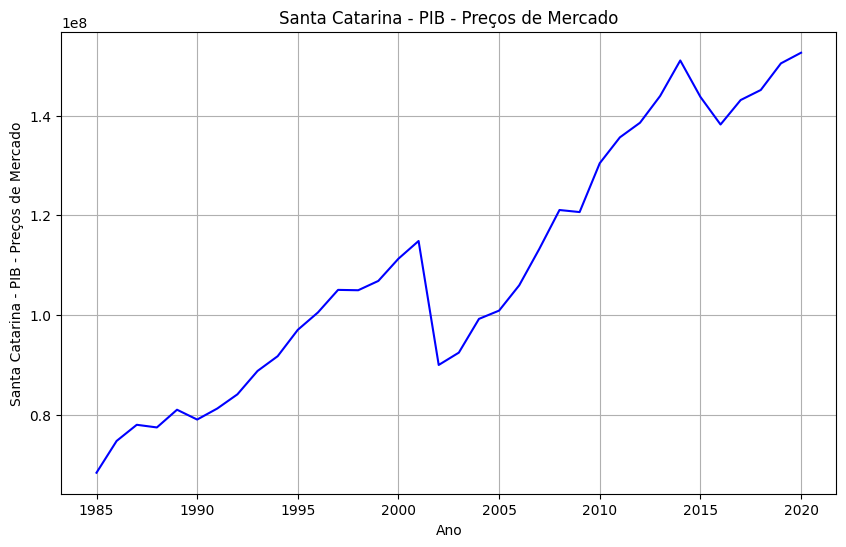

In [4]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF']
for i, column in enumerate(df.columns):
    if i > 0:
        plot_column(df, column, color=colors[i])